In [15]:
import pandas
import io
import uuid
import datetime
import pathlib
from fabric import Connection, Config

import os
import ast
cur_dir=os.getcwd() # save current directory to save the generated CSV files
print(cur_dir)




C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python


In [16]:
location = "nancy"
node = "grouille-1"

config = Config(overrides={
    'timeouts': {
        'connect': 60,  # Connection timeout
        'read': 60,     # Read timeout
    },
    'ssh': {
        'ServerAliveInterval': 60,  # Interval to send keep-alive packets
        'ServerAliveCountMax': 10    # Max keep-alive packets without response
    }
})
c1 = Connection(host='ccaulier@access.grid5000.fr')
# print(c1.run("hostname"))
c2 = Connection(host='ccaulier@{}'.format(location), gateway=c1)
# print(c2.run("hostname"))
c = Connection(host='ccaulier@{}'.format(node), gateway=c2)
# c =c2

In [17]:

n_window = 1440
n_elements_per_window = 100000
# pathlib.Path(experimentDirectory).mkdir(exist_ok=True, parents=True)
n_experiments = 5
start_experiment = 1
source_parallelism = 24
main_parallelism = 24
aggregator_parallelism = 4


experimentName = "%s_w%s_s%s_p%s_a%s" % (n_elements_per_window, n_window,  source_parallelism, main_parallelism, aggregator_parallelism)
experimentDirectory = "%s/experiments/experiment_%s/" % (cur_dir,experimentName)
# dataDirectory = "param_100000_1440.csv"
dataDirectory = "param_100000_1440.csv"



In [18]:
import time

def getTempData(notebook_dir,remote_output_file, local_output_file, remote_throughput_file, local_throughput_file):
    # c.get(remote_output_file, "%s/%s" % (notebook_dir, local_output_file))
    c.get(remote_throughput_file, "%s/%s" % (notebook_dir, local_throughput_file))
    return
def runExperiment(source_parallelism,main_parallelism, aggregator_parallelism ,notebook_dir, dataFileDirectory, remote_output_file, local_output_file, remote_throughput_file, local_throughput_file):
    c.run("./flink-1.18.1/bin/start-cluster.sh")

    time.sleep(30)
    c.run("bash runPrometheusAndFlink.sh {} {} {} {} {}".format(source_parallelism,main_parallelism, aggregator_parallelism, dataFileDirectory, "javaSource"))
    print("python fakePrometheus.py > throughput.dat &")

    print("running flink jobs")
    time.sleep(5)
    c.get(remote_output_file, "%s/%s" % (notebook_dir, local_output_file))
    c.get(remote_throughput_file, "%s/%s" % (notebook_dir, local_throughput_file))
    c.run("flink-1.18.1/bin/stop-cluster.sh")
    time.sleep(15)
    return


In [19]:
# getTempData("%s%s" % ( experimentDirectory, "temp" ), "output.dat", "output.dat", "throughput.dat", "throughput.dat")

Experiment 0
Starting cluster.
Starting standalonesession daemon on host grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 1 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 2 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 3 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 4 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 5 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 6 instance(s) of taskexecutor are alre

Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)


UnexpectedExit: Encountered a bad command exit code!

Command: 'bash runPrometheusAndFlink.sh 6 6 1 param_lowThenHighSkew.csv javaSource'

Exit code: -1

Stdout: already printed

Stderr: already printed



In [ ]:
for i in range(start_experiment, n_experiments):
    print("Experiment %s" % i)
    currentExperimentDirectory = "%s%s" % ( experimentDirectory, i )
    pathlib.Path(currentExperimentDirectory).mkdir(exist_ok=True, parents=True)

    runExperiment(source_parallelism,main_parallelism, aggregator_parallelism, currentExperimentDirectory, dataDirectory, "output.dat", "output.dat", "throughput.dat", "throughput.dat")

Experiment 2
Starting cluster.
Starting standalonesession daemon on host grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 1 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 2 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 3 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 4 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 5 instance(s) of taskexecutor are already running on grouille-1.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-1.nancy.grid5000.fr.
[INFO] 6 instance(s) of taskexecutor are alre

In [16]:
import pandas as pd
import re


def parse_data_javaSource(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            metric_data.insert(5,"javaSource")
            metric_data[8], metric_data[9] = metric_data[9], metric_data[8]


            if(metric_data[10] == "1.0E-15"):
                metric_data[10] = "0.0"

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            print(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df

# def parse_throughput_data(file_path):

def save_dataframe_to_csv(df, output_path):
    df.to_csv(output_path, index=False)


# n_experiments = 3
main_df =pd.DataFrame()
for i in range(n_experiments):

    experimentFile = "%s%s/output.dat" % ( experimentDirectory, i )
    print(experimentFile)
    df= parse_data_javaSource(experimentFile)
    save_dataframe_to_csv(df,"%s%s/output.csv" % ( experimentDirectory, i ))
    main_df = pd.concat([main_df, df], ignore_index=True)

# main_df.to_csv(main_df)

C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiments/experiment_400000_w360_s24_p24_a4/0/output.dat
['MeanHybrid', '35057', '12', '12', '0', 'javaSource', 'zipf', '400000', '1', '360', '0.0', 30913]
['MeanHybrid', '27670', '12', '12', '0', 'javaSource', 'zipf', '400000', '1', '360', '0.7', 22263]
['MeanHybrid', '40028', '12', '12', '0', 'javaSource', 'zipf', '400000', '1', '360', '1.4', 35129]
['MeanHybrid', '25858', '12', '12', '0', 'javaSource', 'zipf', '400000', '1', '360', '2.1', 21203]
['MeanHybrid', '23887', '12', '12', '0', 'javaSource', 'zipf', '400000', '2', '360', '0.0', 20508]
['MeanHybrid', '21895', '12', '12', '0', 'javaSource', 'zipf', '400000', '2', '360', '0.7', 17906]
['MeanHybrid', '21912', '12', '12', '0', 'javaSource', 'zipf', '400000', '2', '360', '1.4', 18562]
['MeanHybrid', '21845', '12', '12', '0', 'javaSource', 'zipf', '400000', '2', '360', '2.1', 16996]
['MeanHybrid', '23879', '12', '12', '0', 'javaSource', 'zipf', '

In [17]:
main_df

,Operator,Duration,MainParallelism,HybridParallelism,Choices,CSVSource,distributionType,eventPerWindow,keySize,amountOfWindows,skew,Runtime (ms)
0,MeanHybrid,35057,12,12,0,javaSource,zipf,400000,1,360,0.0,30913
1,MeanHybrid,27670,12,12,0,javaSource,zipf,400000,1,360,0.7,22263
2,MeanHybrid,40028,12,12,0,javaSource,zipf,400000,1,360,1.4,35129
3,MeanHybrid,25858,12,12,0,javaSource,zipf,400000,1,360,2.1,21203
4,MeanHybrid,23887,12,12,0,javaSource,zipf,400000,2,360,0.0,20508
...,...,...,...,...,...,...,...,...,...,...,...,...
127,MeancAM,119903,24,0,3,javaSource,zipf,400000,2,360,2.1,115552
128,MeancAM,21812,24,0,3,javaSource,zipf,400000,3,360,0.0,18105
129,MeancAM,23922,24,0,3,javaSource,zipf,400000,3,360,0.7,19115
130,MeancAM,65848,24,0,3,javaSource,zipf,400000,3,360,1.4,60953


In [18]:
import matplotlib.pyplot as plt

# Group data and calculate mean and range of runtime
main_df.drop(columns=['Duration'])
main_df['amountOfWindows'] = main_df['amountOfWindows'].astype(int)
main_df['eventPerWindow'] = main_df['eventPerWindow'].astype(int)
main_df['Runtime (ms)'] = main_df['Runtime (ms)'].astype(float)

main_df['Throughput (events/sec)'] = (main_df['amountOfWindows'] * main_df['eventPerWindow']) / (main_df['Runtime (ms)'] / 1000)
grouped = main_df.groupby(['Operator', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew'])
runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'}).reset_index()



throughput_stats = grouped['Throughput (events/sec)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'}).reset_index()

runtime_stats

,Operator,MainParallelism,HybridParallelism,Choices,CSVSource,distributionType,eventPerWindow,keySize,amountOfWindows,skew,mean,range
0,MeanCAMRoundRobin,24,0,3,javaSource,zipf,400000,1,360,0.0,18725.0,0.0
1,MeanCAMRoundRobin,24,0,3,javaSource,zipf,400000,1,360,0.7,23281.0,0.0
2,MeanCAMRoundRobin,24,0,3,javaSource,zipf,400000,1,360,1.4,14650.0,0.0
3,MeanCAMRoundRobin,24,0,3,javaSource,zipf,400000,1,360,2.1,12827.0,0.0
4,MeanCAMRoundRobin,24,0,3,javaSource,zipf,400000,2,360,0.0,21157.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
127,MeancAM,24,0,3,javaSource,zipf,400000,2,360,2.1,115552.0,0.0
128,MeancAM,24,0,3,javaSource,zipf,400000,3,360,0.0,18105.0,0.0
129,MeancAM,24,0,3,javaSource,zipf,400000,3,360,0.7,19115.0,0.0
130,MeancAM,24,0,3,javaSource,zipf,400000,3,360,1.4,60953.0,0.0


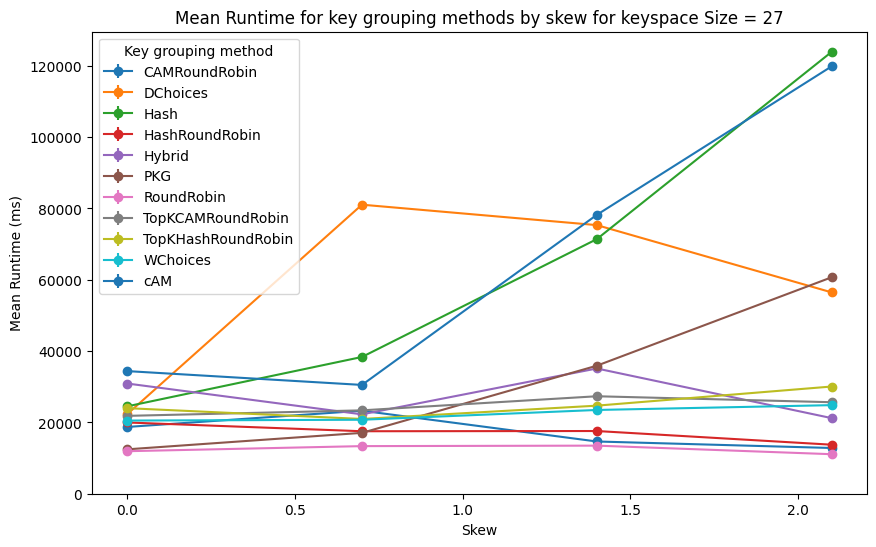

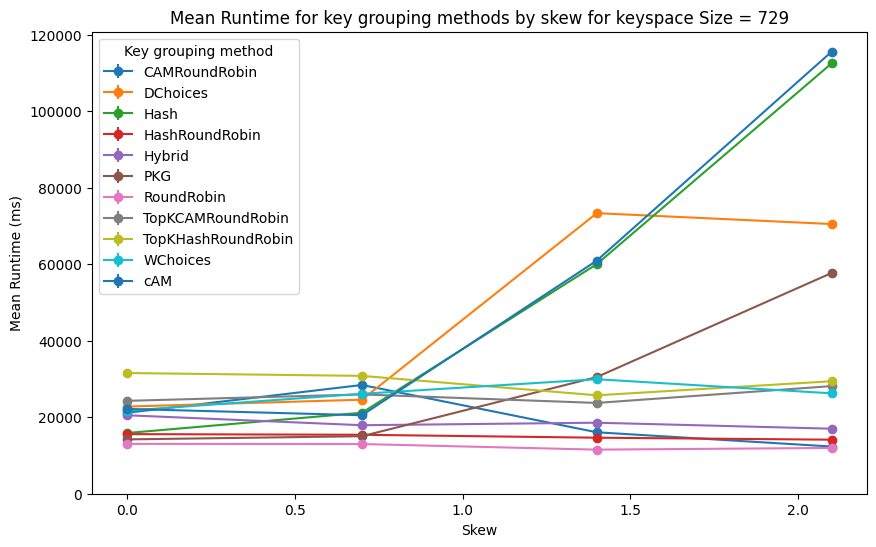

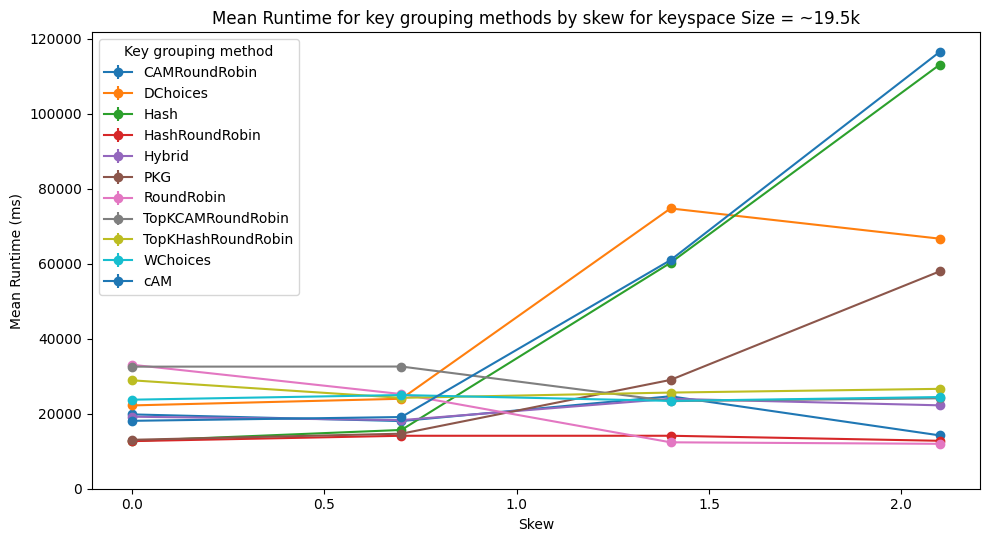

In [19]:
#PLOT FOR RUNTIME
runtime_stats['skew'] = runtime_stats['skew'].astype(float)
listOfKeySizes = [27**1, 27**2, "~19.5k"]
sorted_runtime_stats = runtime_stats.sort_values(by='skew')
for i in range(1,3+1):
    keysize_2_data = runtime_stats[runtime_stats['keySize'] == str(i)].sort_values(by='skew')


    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            # print(group['skew'])
            ax.errorbar(group['skew'], group['mean'], yerr=group['range']/2, fmt='-o', label=f'{name[4:]}')
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Mean Runtime (ms)')
    ax.set_title('Mean Runtime for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
     # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    # plt.show()
    plt.savefig(experimentDirectory+"plot{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()



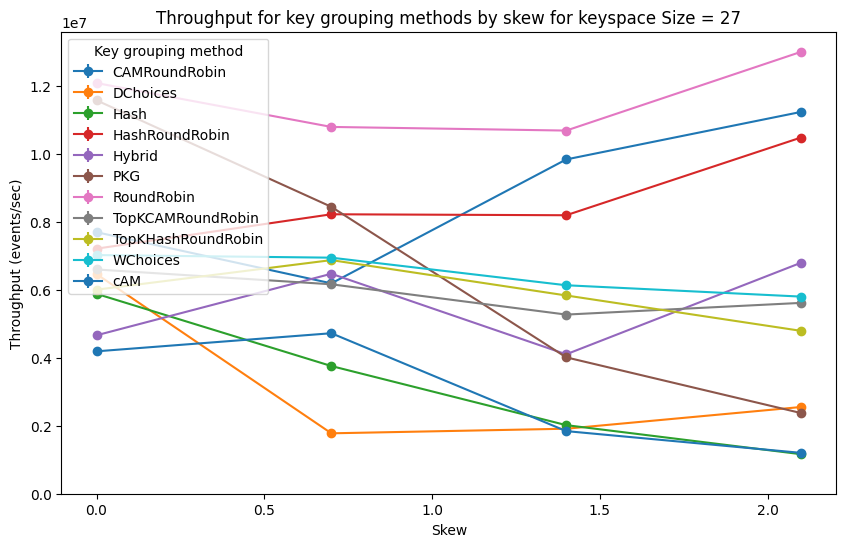

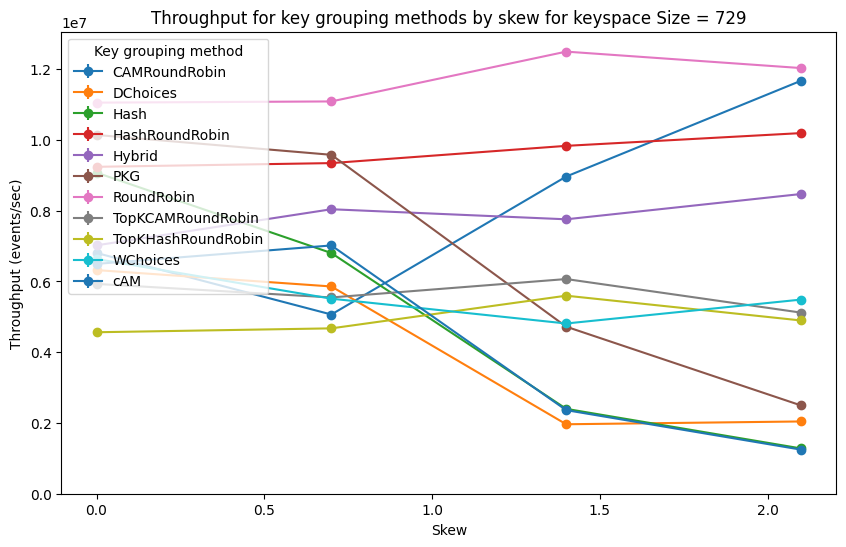

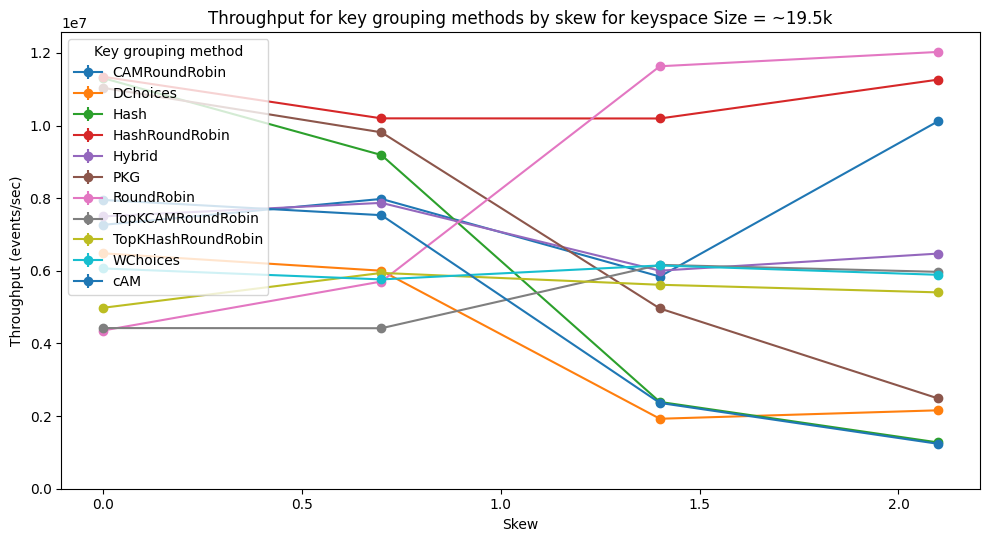

In [20]:
#PLOTS FOR THROUGHPUT
# Plot for Throughput
throughput_stats['skew'] = throughput_stats['skew'].astype(float)
listOfKeySizes = [27**1, 27**2, "~19.5k"]
sorted_throughput_stats = throughput_stats.sort_values(by='skew')

for i in range(1, 3+1):
    keysize_2_data = throughput_stats[throughput_stats['keySize'] == str(i)].sort_values(by='skew')

    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            ax.errorbar(group['skew'], group['mean'], yerr=group['range']/2, fmt='-o', label=f'{name[4:]}')
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Throughput (events/sec)')
    ax.set_title('Throughput for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
    # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    plt.savefig("plot_throughput_{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
#PLOTS FOR GINI COEFFICIENT OF INTPUT


In [ ]:
#PLOTS FOR INPUT TOTAL OUTPUT  /TOTAL THROUGHPUT